# NHSBSA English Prescribing Data (EPD) Analysis

##                            Part 1: Data Extraction and Transformation

API documentation https://docs.ckan.org/en/2.8/api/

In [1]:
#Import the requests module. This module is used to send HTTP requests in python.
import requests  

#The url below is described within the API documentation and is used to view the datasets available.
url = "http://opendata.nhsbsa.net/api/3/action/package_list"

#Response.get sends a get request to obtain data from a url.
response = requests.get(url)

#The status code below is used to ensure the request has/can be made successfully.
#Status code 200 means the request was successful.

response.status_code

200

In [2]:
#Display the response in dictionary format.
response.json()

{'help': 'https://opendata.nhsbsa.net/api/3/action/help_show?name=package_list',
 'success': True,
 'result': ['english-prescribing-data-epd',
  'english-prescribing-dataset-epd-with-snomed-code',
  'prescription-cost-analysis-pca-annual-statistics',
  'prescription-cost-analysis-pca-monthly-data',
  'secondary-care-medicines-data']}

In [3]:
#Print the values in the 'result' key.
#The 'result' key contains the names of datasets available.

#Only three datasets are available.
print(response.json()['result'])

['english-prescribing-data-epd', 'english-prescribing-dataset-epd-with-snomed-code', 'prescription-cost-analysis-pca-annual-statistics', 'prescription-cost-analysis-pca-monthly-data', 'secondary-care-medicines-data']


In [4]:
#Using the API documentation, the url containing the medicines data was used and tested using response.status_code
url2 = "http://opendata.nhsbsa.net/api/3/action/package_show?id=english-prescribing-data-epd"
response2 = requests.get(url2)
response2_json = response2.json() 
response2.status_code

200

In [5]:
#The keys within the output of the results were investigated.
response2_json['result'].keys()

dict_keys(['num_resources', 'maintainer', 'tags', 'relationships_as_object', 'private', 'maintainer_email', 'num_tags', 'groups', 'license_id', 'isopen', 'id', 'metadata_created', 'organization', 'name', 'metadata_modified', 'author', 'author_email', 'notes', 'license_title', 'owner_org', 'relationships_as_subject', 'url', 'state', 'version', 'title', 'creator_user_id', 'revision_id', 'type', 'resources', 'extras'])

In [6]:
#Each dataset for medicines in secondary care is stored within csv files downloadable through a url.
response2_json['result']['resources'][0]['url']

'https://opendata.nhsbsa.net/dataset/65050ec0-5abd-48ce-989d-defc08ed837e/resource/8ae6b792-2a0c-4f4b-826c-dc6483dc32a7/download/epd_201401.csv'

In [7]:
datasets =[]
for num in range(len(response2_json['result']['resources'])):
    datasets.append(response2_json['result']['resources'][num]['url'])
#datasets

# Memory

2019's prescribing data can now be found in datasets[60:72], however, an attempt to read all of the CSVs into memory using Pandas will result in wastage of hours followed by a crash.

An option is to read the CSVs in chunks, however, I soon learnt that there just is not enough memory to complete the task in a manner which is efficient and allows for reproduction. My Macbook possesses a meagre 8GB of memory. "Restart and Run All Cells" became synonymous with "waste the whole weekend".

The solution? Read only the features and records which are required. There is also a need to investigate the data types which take up less memory and apply necessary changes to features whilst reading.

In [8]:
#Here, an entire CSV (one month) is read to memory. The size can be seen below.


import pandas as pd
test_df = pd.read_csv(datasets[60], sep =",")

In [9]:
test_df.info(memory_usage='deep', null_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18216730 entries, 0 to 18216729
Data columns (total 26 columns):
 #   Column                        Non-Null Count     Dtype  
---  ------                        --------------     -----  
 0   YEAR_MONTH                    18216730 non-null  int64  
 1   REGIONAL_OFFICE_NAME          18216730 non-null  object 
 2   REGIONAL_OFFICE_CODE          18216730 non-null  object 
 3   AREA_TEAM_NAME                18216730 non-null  object 
 4   AREA_TEAM_CODE                18216730 non-null  object 
 5   PCO_NAME                      18216730 non-null  object 
 6   PCO_CODE                      18216730 non-null  object 
 7   PRACTICE_NAME                 18216730 non-null  object 
 8   PRACTICE_CODE                 18216730 non-null  object 
 9   ADDRESS_1                     18198587 non-null  object 
 10  ADDRESS_2                     17278708 non-null  object 
 11  ADDRESS_3                     17761951 non-null  object 
 12  ADDRESS_4   

In [10]:
#test_df.memory_usage(deep=True)

In [11]:
#Let's free up that memory!

del test_df

As can be seen above, a full reading of only one CSV assumes  MB of memory. This is not efficient. Below a function which reads a list of urls in Pandas whilst preparing the data to use memory effificiently is defined.

In [12]:
from datetime import datetime

def LargeCSVsChop(listofCSV_URLs):
    
    
    dfs = []
    for num in range(len(listofCSV_URLs)):

        feats = ['YEAR_MONTH', 'PCO_NAME', 'PRACTICE_NAME', 'CHEMICAL_SUBSTANCE_BNF_DESCR', 
                'BNF_DESCRIPTION', 'TOTAL_QUANTITY', 'ACTUAL_COST']
        
        custom_date_parser = lambda x: datetime.strptime(x, "%Y%m")
        
        df = pd.read_csv(listofCSV_URLs[num], sep =",", usecols = feats, date_parser=custom_date_parser,
                                                                         parse_dates=['YEAR_MONTH'])
        
        """"
        'feats' is a list of the columns/features from the CSV that I want Pandas to read to memory.
        
        types = {'TOTAL_QUANTITY': int, 'ACTUAL_COST':float}
        
        Types is a dictionary of columns and the datatypes they should be read as using dtypes = types in the read_csv function. 
        
        The types are optimal so no changes will be made but the dictionary can be used in future.    
        
        
        'custom_data_parser' will be used to convert the dtype of the YEAR_MONTH feature to date format.

        
        
        The dataframe will read only feats and convert the dtype of the YEAR_MONTH feature.
        
        'df' is used as a variable again for the filtered dataframe to prompt the deallocation of the unfiltered
        #dataframe object from memory by dropping the reference count to zero and prompting garbage collection algorithms.
        
        
        Oral antihistamines will be the focus of this analysis. 'CHEMICAL_SUBSTANCE_BNF_DESCR' is used to ensure all
        forms and brads of the drugs are captured. Further work is done using 'BNF_DESCRIPTION' to remove unwanted products.
        
        """
        
        df = df[ 
               (df['CHEMICAL_SUBSTANCE_BNF_DESCR']=='Cetirizine hydrochloride')                              | 
               (df['CHEMICAL_SUBSTANCE_BNF_DESCR']=='Loratadine')                                            |
               (df['CHEMICAL_SUBSTANCE_BNF_DESCR']=='Desloratadine')                                         |
               (df['CHEMICAL_SUBSTANCE_BNF_DESCR']=='Fexofenadine hydrochloride')                            |
               (df['CHEMICAL_SUBSTANCE_BNF_DESCR']=='Acrivastine')                                           |
               (df['CHEMICAL_SUBSTANCE_BNF_DESCR']=='Bilastine')                                             |
               (df['CHEMICAL_SUBSTANCE_BNF_DESCR']=='Levocetirizine')                                        |
               (df['CHEMICAL_SUBSTANCE_BNF_DESCR']=='Mizolastine')                                           |
               (df['CHEMICAL_SUBSTANCE_BNF_DESCR']=='Chlorphenamine maleate')                                & 
               (df['BNF_DESCRIPTION']!='Chlorphenamine 10mg/1ml solution for injection ampoules')            |
               (df['CHEMICAL_SUBSTANCE_BNF_DESCR']=='Promethazine hydrochloride')                            &
               (df['BNF_DESCRIPTION']!='Promethazine 25mg/1ml solution for injection ampoules')              &
               (df['BNF_DESCRIPTION']!='Phenergan 25mg/1ml solution for injection ampoules')                   
             ]
      
        dfs.append(df)
        
    df_large = pd.concat(dfs)
        
    return df_large

One dataframe read this way uses a lot less memory (13MB) but another huge problem now exists. 

In [13]:
Jan_2019_df = LargeCSVsChop(datasets[60:61])

In [14]:
Jan_2019_df.info(memory_usage='deep', null_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213217 entries, 551 to 18216332
Data columns (total 7 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   YEAR_MONTH                    213217 non-null  datetime64[ns]
 1   PCO_NAME                      213217 non-null  object        
 2   PRACTICE_NAME                 213217 non-null  object        
 3   CHEMICAL_SUBSTANCE_BNF_DESCR  213217 non-null  object        
 4   BNF_DESCRIPTION               213217 non-null  object        
 5   TOTAL_QUANTITY                213217 non-null  float64       
 6   ACTUAL_COST                   213217 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 71.4 MB


# Time

The issue of time is partially solved by reading only the features required for the dataframe as demonstrated below. Hoever, bandwidth is another limitation, this work requires pandas to parce a CSV though a URL; low speeds will ensure the process is slow regardless of how (in)efficient this process is for Pandas.

In [15]:
import time
import numpy as np

def timefunc(function, arg, repeats = 20):
    
    alltime = []
    
    while  repeats > 0:
        
        """
        Unless specified, the number of repitions will be 20.
        
        
        """
        
        starttime= time.time() # record the start time

        result = function(arg) # run the function and store in the variable 'result' in case result is needed.

        endtime = time.time() # Record end time.

        timetaken = endtime - starttime 
        
        alltime.append(timetaken) 
        
        repeats -=1  
        
    mean = np.mean(alltime) #Find the mean.
    std = np.std(alltime) #Find the standard deviation.
    error=std/(len(alltime)**0.5)   #Find the standard error.
    
    return (mean)

In [16]:
def FuncReadCSV(listofdataframes):
    
    frames = []
    for csv in listofdataframes:
        df = pd.read_csv(csv)
        frames.append(df)
        dfs= pd.concat(frames)
    return df

Without_ncols = timefunc(FuncReadCSV, datasets[60:62], repeats = 1)

#Return the mean timetaken to run read a list of CSVs without removing columns or filtering records.

In [17]:
def LargeCSVsChop_MINI(listofCSV_URLs):
    
    """
    The same as LargeCSVsChop without the filtering element. This is to enable like for like
    comparisons as much as possible (with the exception of date parsing) as it pertains to time

    """
    dfs = []
    for num in range(len(listofCSV_URLs)):

        feats = ['YEAR_MONTH', 'PCO_NAME', 'PRACTICE_NAME', 'CHEMICAL_SUBSTANCE_BNF_DESCR', 
                'BNF_DESCRIPTION', 'TOTAL_QUANTITY', 'ACTUAL_COST']
        
        custom_date_parser = lambda x: datetime.strptime(x, "%Y%m")
        
        df = pd.read_csv(listofCSV_URLs[num], sep =",", usecols = feats, date_parser=custom_date_parser,
                                                                         parse_dates=['YEAR_MONTH'])
      
        dfs.append(df)
        
    df_large = pd.concat(dfs)
        
    return df_large



With_ncols = timefunc(LargeCSVsChop_MINI, datasets[60:62], repeats = 1)

#Return the mean time taken to read one CSV using the LargeCSVsChop_MINI function.

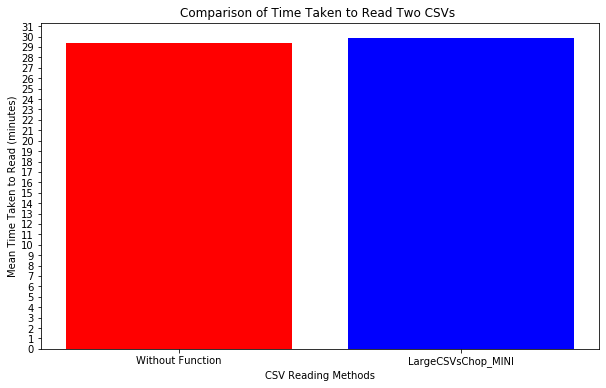

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax1=plt.subplots(figsize=(10,6))

plt.xlabel('CSV Reading Methods')
plt.ylabel('Mean Time Taken to Read (minutes)')
plt.title('Comparison of Time Taken to Read Two CSVs ')

plt.yticks(range(100))
            
plt.bar(height=Without_ncols/60,x = 'Without Function', color = 'red')
plt.bar(height=With_ncols/60,x='LargeCSVsChop_MINI', color = 'blue')
plt.savefig('Time taken')

#Bearing in mind that the LargeCSVsChop function doesn't just read to dataframe. It also parses the YEAR_MONTH column to

### Whole year of Data

Each csv is read in individual lines as opposed to one to allow for fleixibility when the kernel needs to be interrupted due to the time taken or any other issue.

In [ ]:
Feb_2019_df = LargeCSVsChop(datasets[61:62])

In [ ]:
Mar_2019_df = LargeCSVsChop(datasets[62:63])

In [ ]:
Apr_2019_df = LargeCSVsChop(datasets[63:64])

In [ ]:
May_2019_df = LargeCSVsChop(datasets[64:65])

In [ ]:
Jun_2019_df = LargeCSVsChop(datasets[65:66])

In [ ]:
Jul_2019_df = LargeCSVsChop(datasets[66:67])

In [ ]:
Aug_2019_df = LargeCSVsChop(datasets[67:68])

In [ ]:
Sep_2019_df = LargeCSVsChop(datasets[68:69])

In [ ]:
Oct_2019_df = LargeCSVsChop(datasets[69:70])

In [ ]:
Nov_2019_df = LargeCSVsChop(datasets[70:71])

In [ ]:
Dec_2019_df = LargeCSVsChop(datasets[71:72])

In [ ]:
HayFev_df_2019_list = [Jan_2019_df,Feb_2019_df ,Mar_2019_df,Apr_2019_df,May_2019_df,Jun_2019_df,Jul_2019_df,
                       Aug_2019_df,Sep_2019_df,Oct_2019_df,Nov_2019_df,Dec_2019_df ]

HayFev_df_2019 = pd.concat(HayFev_df_2019_list)

HayFev_df_2019.to_csv('HayFev_df_2019.csv') 

In [ ]:
#HayFev_df_2019.info()

Given the cost of hardware, I am more inclined to look for workarounds such as these to facilitate and speed up personal projects. I hope this has been useful to others and I would love comments and feedback on my code. 

